# EGS master catalogue
## Preparation of IRAC-EGS data

IRAC-EGS catalogue: the catalogue comes from `dmu0_IRAC-EGS`.

In the catalogue, we keep:

- The identifier (it's unique in the catalogue);
- The position;
- The total flux (no aperture fluxes given).

We don't know when the maps have been observed. We will use the year of the reference paper.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was run with herschelhelp_internal version: 
0246c5d (Thu Jan 25 17:01:47 2018 +0000) [with local modifications]
This notebook was executed on: 
2018-02-07 16:47:17.065467


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, flux_to_mag

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "irac-egs_ra"
DEC_COL = "irac-egs_dec"

## I - Column selection

In [4]:
imported_columns = OrderedDict({
        'no.': "irac-egs_id",
        'ALPHA_GR_DEC_ORDER': "irac-egs_ra",
        'DELTA_GR_DEC_ORDER': "irac-egs_dec",
        'irac36_final': "f_irac-egs_i1", 
        'err_irac36_final': "ferr_irac-egs_i1", 
        'irac45_final': "f_irac-egs_i2", 
        'err_irac45_final': "ferr_irac-egs_i2", 
        'irac58_final': "f_irac-egs_i3", 
        'err_irac58_final': "ferr_irac-egs_i3", 
        'irac80_final': "f_irac-egs_i4", 
        'err_irac80_final': "ferr_irac-egs_i4", 
    
    #Subaru suprime
    'SUBARU_R': 'f_suprime_r',
    'err_SUBARU_R': 'ferr_suprime_r',
    
    #CFHT megacam and cfht12k
    'CFHT_u': 'f_irac-megacam_u',
    'err_CFHT_u': 'ferr_irac-megacam_u',
    'CFHT_g': 'f_irac-megacam_g',
    'err_CFHT_g': 'ferr_irac-megacam_g',
    'CFHT_r': 'f_irac-megacam_r',
    'err_CFHT_r': 'ferr_irac-megacam_r',
    'CFHT_i': 'f_irac-megacam_i',
    'err_CFHT_i': 'ferr_irac-megacam_i',
    'CFHT_z': 'f_irac-megacam_z',
    'err_CFHT_z': 'ferr_irac-megacam_z',
    
    'CFHT12k_B': 'f_cfht12k_b',
    'err_CFHT12k_B': 'ferr_cfht12k_b',
    'CFHT12k_R': 'f_cfht12k_r',
    'err_CFHT12k_R': 'ferr_cfht12k_r',
    'CFHT12k_I': 'f_cfht12k_i',
    'err_CFHT12k_I': 'ferr_cfht12k_i',
    
    #HST
    'ACS_i': 'f_irac-acs_f814w' ,
    'err_ACS_i': 'ferr_irac-acs_f814w' ,
    'ACS_v': 'f_irac-acs_f606w' ,
    'err_ACS_v': 'ferr_irac-acs_f606w' ,
    'NICMOS_F110W': 'f_nicmos_f110w',
    'err_NICMOS_F110W': 'ferr_nicmos_f110w',
    'NICMOS_F160W': 'f_nicmos_f160w',
    'err_NICMOS_F160W': 'ferr_nicmos_f160w',
    
    #Subaru MOIRCS
    'MOIRCS_K_AEGIS': 'f_moircs_ks',
    'err_MOIRCS_K_AEGIS': 'ferr_moircs_ks',
    
    #AEGIS - wircs instrument on Palomar?
    'AEGIS_J': 'f_irac-aegis_j',
    'err_AEGIS_J': 'ferr_irac-aegis_j',
    'AEGIS_K': 'f_irac-aegis_k',
    'err_AEGIS_K': 'ferr_irac-aegis_k',
    
    #CAHA omega prime
    'UCM_NB_J': 'f_omega2000_j',
    'err_UCM_NB_J': 'ferr_omega2000_j',
    'UCM_FF_K': 'f_omega2000_ks',
    'err_UCM_FF_K': 'ferr_omega2000_ks',
    

    #MMT MegaCam instrument
    'MMT_u': 'f_mmt_u',
    'err_MMT_u': 'ferr_mmt_u',
    'MMT_g': 'f_mmt_g',
    'err_MMT_g': 'ferr_mmt_g',
    'MMT_i': 'f_mmt_i',
    'err_MMT_i': 'ferr_mmt_i',
    'MMT_z': 'f_mmt_z',
    'err_MMT_z': 'ferr_mmt_z',
    
    
    })


catalogue = Table.read("../../dmu0/dmu0_IRAC-EGS/data/IRAC_EGS.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2011 # TODO: Check

# Clean table metadata
catalogue.meta = None

In [5]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('f_'):
        
        errcol = "ferr{}".format(col[1:])
        
        # Some object have a magnitude to 0, we suppose this means missing value
        mask = (np.isclose(catalogue[col], -99.) 
                | np.isclose(catalogue[errcol], -99.)
                | np.isclose(catalogue[col], 0.0) )
        catalogue[col][mask ] = np.nan
        catalogue[errcol][mask] = np.nan  
        
        #fluxes already in uJy
        
        mag, error = flux_to_mag(np.array(catalogue[col])*1.e-6, np.array(catalogue[errcol])*1.e-6)
        
        
        catalogue.add_column(Column(mag , name="m{}".format(col[1:])))
        catalogue.add_column(Column(error , name="m{}".format(errcol[1:])))
        
        # Add empty aperture columns
        #catalogue.add_column(Column(np.full(len(catalogue), np.nan), name="m_ap{}".format(col[1:])))
        #catalogue.add_column(Column(np.full(len(catalogue), np.nan), name="merr_ap{}".format(col[1:])))
        #catalogue.add_column(Column(np.full(len(catalogue), np.nan), name="f_ap{}".format(col[1:])))
        #catalogue.add_column(Column(np.full(len(catalogue), np.nan), name="ferr_ap{}".format(col[1:])))
        
        
        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

In [6]:
catalogue[:10].show_in_notebook()

idx,irac-egs_id,irac-egs_ra,irac-egs_dec,f_irac-egs_i1,ferr_irac-egs_i1,f_irac-egs_i2,ferr_irac-egs_i2,f_irac-egs_i3,ferr_irac-egs_i3,f_irac-egs_i4,ferr_irac-egs_i4,f_suprime_r,ferr_suprime_r,f_irac-megacam_u,ferr_irac-megacam_u,f_irac-megacam_g,ferr_irac-megacam_g,f_irac-megacam_r,ferr_irac-megacam_r,f_irac-megacam_i,ferr_irac-megacam_i,f_irac-megacam_z,ferr_irac-megacam_z,f_cfht12k_b,ferr_cfht12k_b,f_cfht12k_r,ferr_cfht12k_r,f_cfht12k_i,ferr_cfht12k_i,f_irac-acs_f814w,ferr_irac-acs_f814w,f_irac-acs_f606w,ferr_irac-acs_f606w,f_nicmos_f110w,ferr_nicmos_f110w,f_nicmos_f160w,ferr_nicmos_f160w,f_moircs_ks,ferr_moircs_ks,f_irac-aegis_j,ferr_irac-aegis_j,f_irac-aegis_k,ferr_irac-aegis_k,f_omega2000_j,ferr_omega2000_j,f_omega2000_ks,ferr_omega2000_ks,f_mmt_u,ferr_mmt_u,f_mmt_g,ferr_mmt_g,f_mmt_i,ferr_mmt_i,f_mmt_z,ferr_mmt_z,m_irac-egs_i1,merr_irac-egs_i1,flag_irac-egs_i1,m_irac-egs_i2,merr_irac-egs_i2,flag_irac-egs_i2,m_irac-egs_i3,merr_irac-egs_i3,flag_irac-egs_i3,m_irac-egs_i4,merr_irac-egs_i4,flag_irac-egs_i4,m_suprime_r,merr_suprime_r,flag_suprime_r,m_irac-megacam_u,merr_irac-megacam_u,flag_irac-megacam_u,m_irac-megacam_g,merr_irac-megacam_g,flag_irac-megacam_g,m_irac-megacam_r,merr_irac-megacam_r,flag_irac-megacam_r,m_irac-megacam_i,merr_irac-megacam_i,flag_irac-megacam_i,m_irac-megacam_z,merr_irac-megacam_z,flag_irac-megacam_z,m_cfht12k_b,merr_cfht12k_b,flag_cfht12k_b,m_cfht12k_r,merr_cfht12k_r,flag_cfht12k_r,m_cfht12k_i,merr_cfht12k_i,flag_cfht12k_i,m_irac-acs_f814w,merr_irac-acs_f814w,flag_irac-acs_f814w,m_irac-acs_f606w,merr_irac-acs_f606w,flag_irac-acs_f606w,m_nicmos_f110w,merr_nicmos_f110w,flag_nicmos_f110w,m_nicmos_f160w,merr_nicmos_f160w,flag_nicmos_f160w,m_moircs_ks,merr_moircs_ks,flag_moircs_ks,m_irac-aegis_j,merr_irac-aegis_j,flag_irac-aegis_j,m_irac-aegis_k,merr_irac-aegis_k,flag_irac-aegis_k,m_omega2000_j,merr_omega2000_j,flag_omega2000_j,m_omega2000_ks,merr_omega2000_ks,flag_omega2000_ks,m_mmt_u,merr_mmt_u,flag_mmt_u,m_mmt_g,merr_mmt_g,flag_mmt_g,m_mmt_i,merr_mmt_i,flag_mmt_i,m_mmt_z,merr_mmt_z,flag_mmt_z
0,1,215.77448,53.566512,378.32,13.781,153.63,5.3276,196.99,5.9567,165.59,6.0094,58.848,-9.7199,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1021.7,-141.16,1632.9,-75.209,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,8.1928,-0.44614,441.46,-12.237,47.77,-1.9498,83.392,-2.9121,17.4553517475,0.0395499329609,False,18.4338099236,0.0376512933963,False,18.1638895495,0.0328311328031,False,18.3524147346,0.0394022776066,False,19.4756707311,-0.179330603192,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,16.3766915165,-0.150007362889,False,15.8676010274,-0.050007431088,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,21.6164191172,-0.0591239076251,False,17.2877716026,-0.0300959406008,False,19.7021118968,-0.0443158562285,False,19.0971890258,-0.0379145769603,False
1,2,215.82287,53.570623,434.06,15.812,206.79,7.1616,252.49,7.5418,125.59,4.6259,13.812,-10.381,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.2875,-0.36967,11.972,-0.83762,0.67684,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.0475,-0.20379,345.17,-9.5608,18.583,-1.0871,37.841,-1.8215,17.3061255848,0.0395513543511,False,18.111176167,0.0376014720441,False,17.8943895442,0.0324306123373,False,18.6526123489,0.0399912979504,False,21.0493585758,-0.816031533565,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,23.0015972432,-0.175459717077,False,21.2045832296,-0.0759634446901,False,24.323784958,0.0,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,nan,nan,False,23.1219402239,-0.108064557347,False,17.5549173936,-0.0300736063576,False,20.7272104328,-0.0635152466336,False,19.9550934882,-0.0522625854752,False
2,3,215.05203,53.124925,1629.8,29.347,1163.2,22.113,952.9,23.765,4564.0,103.76,740.53,13.65,107.26,1

## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [7]:
SORT_COLS = ['ferr_irac-egs_i1', 'ferr_irac-egs_i2', 'ferr_irac-egs_i3', 'ferr_irac-egs_i4']
FLAG_NAME = 'wfc_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 117929 sources.
The cleaned catalogue has 117929 sources (0 removed).
The cleaned catalogue has 0 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [8]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_EGS.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

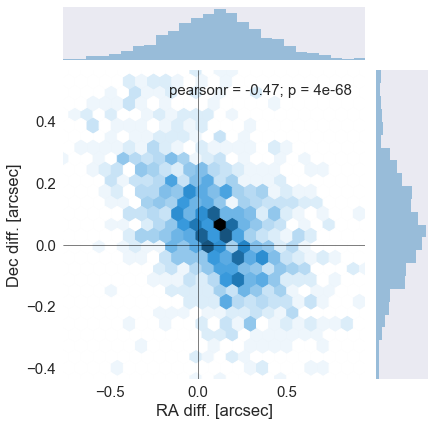

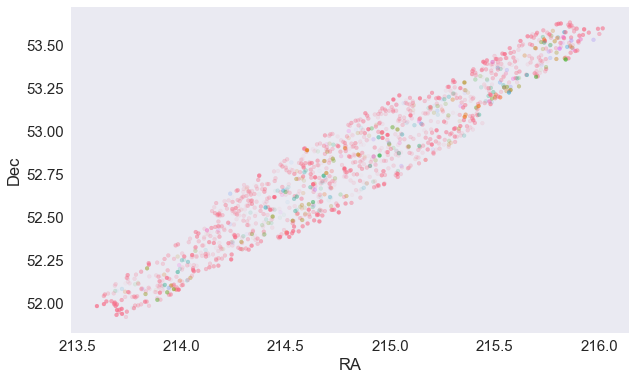

In [9]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [10]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.10139878082782161 arcsec
Dec correction: -0.05154244758358573 arcsec


In [11]:
catalogue[RA_COL] = catalogue[RA_COL] +  delta_ra.to(u.deg)
catalogue[DEC_COL] = catalogue[DEC_COL] + delta_dec.to(u.deg)

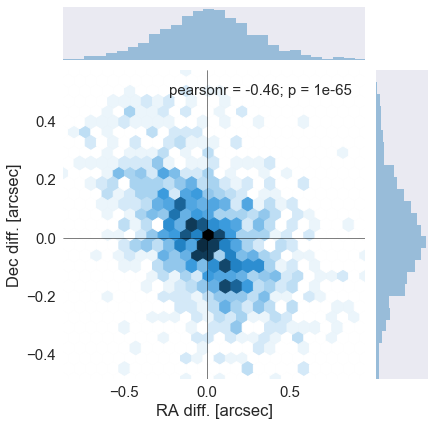

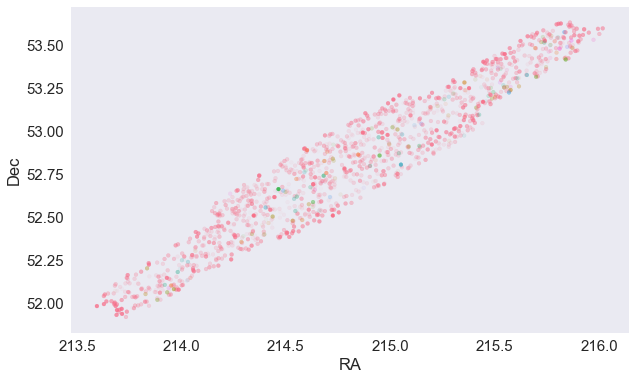

In [12]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [13]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [14]:
GAIA_FLAG_NAME = "irac-egs_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

1297 sources flagged.


# V - Saving to disk

In [15]:
catalogue.write("{}/IRAC-EGS.fits".format(OUT_DIR), overwrite=True)